In [1]:
from __future__ import annotations
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import cv2
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


In [2]:
class_names = ['ZIMMER - LPS','ZIMMER - PERSONA']

"""
Zimmer LPS; Zimmer Persona; Depuy Attune; Maxx Freedom; -> Challenging Classes

Link Gemini SL; Microport Media Pivot; 
Exactech Opterak Logic; Smith and Nephew Legion; Stryker NRG; DJO 3D Knee ->Non Challenging Classes

"""

'\nZimmer LPS; Zimmer Persona; Depuy Attune; Maxx Freedom; -> Challenging Classes\n\nLink Gemini SL; Microport Media Pivot; \nExactech Opterak Logic; Smith and Nephew Legion; Stryker NRG; DJO 3D Knee ->Non Challenging Classes\n\n'

In [3]:
len(class_names)

2

In [4]:
#Augmentation class
class Augmentation:
    
    def __init__(self):
        self.ToTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean = (0.485, 0.456, 0.406), 
                       std = (0.229, 0.224, 0.225))
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=3)
        
    def __call__(self,image):
        image = self.ToTensor(image)

        image = self.normalize(image)
        image = self.gaussian_blur(image)
        
        return image    
"""
Augmentations ->
rotation, translation, rotation + translation, and random image enhancement. 

Each image is augmented 284 times exactly.

"""

'\nAugmentations ->\nrotation, translation, rotation + translation, and random image enhancement. \n\nEach image is augmented 284 times exactly.\n\n'

In [5]:
#Dataset Class

class ImageClassificationDataset(Dataset):
    def __init__(self, data_directory: str, augmentation) -> None:
        
        self.data_dict: pd.DataFrame = ImageClassificationDataset.prepare_dataset(
                                        data_directory= data_directory
                                    )
        
        self.augmentation  = augmentation()
    
    def __len__(self) -> int: 
        return len(self.data_dict)
    
    
    @staticmethod
    def la_encode(c):
                    if c=='ZIMMER - LPS':
                        return 0
                  
                    elif c== 'ZIMMER - PERSONA':
                        return 1
    
    @staticmethod
    def prepare_dataset(data_directory: str) -> pd.DataFrame:
        image_paths: list[str] =  [os.path.join(os.path.join(data_directory, classes),filename).replace("\\",'/') 
                                      for classes in sorted(os.listdir(data_directory)) 
                                      for filename in sorted(os.listdir(os.path.join(data_directory,classes)))]
            
        lab:list[str] = [os.path.join(os.path.join(data_directory, classes),filename).replace("\\",'/').split("/")[3]
                                              for classes in sorted(os.listdir(data_directory)) 
                                              for filename in sorted(os.listdir(os.path.join(data_directory,classes)))]
       
        labels = list()
        for i in lab:
                labels.append(ImageClassificationDataset.la_encode(i))
        
        data_dict: dict[str, list[Union[str, int]]] = {
            'image_path': image_paths,
            'label': labels
        } 
        
        data_dict: pd.DataFrame = pd.DataFrame(data_dict)
        return data_dict
    
    
    
    
    def __getitem__(self, index: int) -> dict[str, torch.tensor]:
        image_path: str = self.data_dict.loc[index, 'image_path']
        
        label = self.data_dict.loc[index, 'label']
        
        image: PIL.Image = Image.open(image_path).convert('RGB')
        image = image.resize((224,224))
        if self.augmentation is not None:
                image: Any = self.augmentation(image)  #RandomResizedCropTransform(image_size=224)(image)
        
        return {
            'independent_variable': image, 'dependent_variable': label
        }

In [7]:
data_directory = "../data/augmented data/" #Path to train data
test_directory = "../data/original test/"  #Path to test data
train_dataset = ImageClassificationDataset(data_directory,Augmentation)
test_dataset = ImageClassificationDataset(test_directory,Augmentation)

In [11]:
#test_dataset[6]  #1 sample value from dataset class

{'independent_variable': tensor([[[-1.7354, -1.7479, -1.7644,  ..., -1.3130, -1.3261, -1.3339],
          [-1.7276, -1.7465, -1.7732,  ..., -1.3283, -1.3514, -1.3605],
          [-1.7277, -1.7483, -1.7771,  ..., -1.3320, -1.3517, -1.3566],
          ...,
          [-1.6111, -1.6103, -1.6217,  ..., -1.7280, -1.7009, -1.6915],
          [-1.6207, -1.6200, -1.6232,  ..., -1.7638, -1.7403, -1.7298],
          [-1.6113, -1.6122, -1.6133,  ..., -1.7867, -1.7736, -1.7688]],
 
         [[-1.7633, -1.7732, -1.7793,  ..., -1.2050, -1.2284, -1.2399],
          [-1.7511, -1.7669, -1.7846,  ..., -1.2042, -1.2332, -1.2439],
          [-1.7406, -1.7588, -1.7823,  ..., -1.1907, -1.2065, -1.2101],
          ...,
          [-1.6733, -1.6683, -1.6679,  ..., -1.7055, -1.6831, -1.6746],
          [-1.6797, -1.6752, -1.6704,  ..., -1.7278, -1.7129, -1.7036],
          [-1.6617, -1.6594, -1.6564,  ..., -1.7442, -1.7416, -1.7381]],
 
         [[-1.3563, -1.3647, -1.3682,  ..., -0.3270, -0.3530, -0.3660],
    

In [9]:
train_dataset[0]["independent_variable"].shape

torch.Size([3, 224, 224])

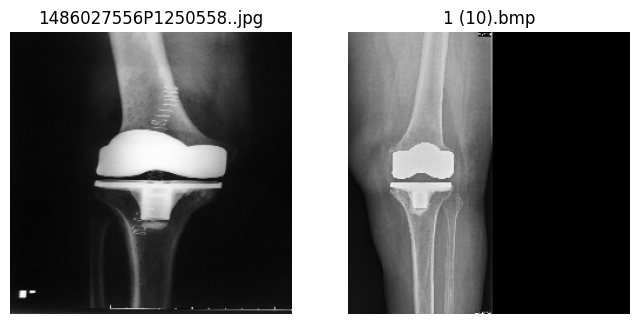

In [10]:
import os
import matplotlib.pyplot as plt
import random

# Set the directory containing the image subdirectories
dir_path = test_directory

# Get the subdirectories in the directory
subdirectories = os.listdir(dir_path)

# Create a figure with subplots for each class
fig, axs = plt.subplots(1, len(subdirectories), figsize=(8, 8))

# Iterate over the subdirectories and select one image from each class to display
for i, subdir in enumerate(subdirectories):
    class_path = os.path.join(dir_path,subdir)
    images_path =os.listdir(class_path)
    img=cv2.imread(class_path+"/"+images_path[0],0)
    img = cv2.resize(img,(240,240))
    axs[i].imshow(img,plt.cm.gray)
    axs[i].axis("off")
    axs[i].set_title(images_path[0])
        

In [11]:
#Trainer Class
class ImageClassifierTrainer:
    def __init__(self, model: torch.nn.Module, train_dataset: ImageClassificationDataset,test_dataset: ImageClassificationDataset,batch_size: Optional[int] = 64, 
                                                                                    learning_rate: Optional[float] = 0.001, 
                                                                                    num_epochs: Optional[int] = 10, 
                                                                                    device: Optional[str] = 'cuda' ) -> None:
        
        self.model = model.to(device)
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.num_epochs = num_epochs
        
        
        self.train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle = True)
        
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr= learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,factor=0.1,patience=5)
        
        self.history: dict[str, list[float]] = {
            'train_loss': [], 'train_acc': [],
            'test_loss': [], 'test_acc': []
        }
    
        self.dependent_values = {
            'target' : [],
            'predicted' : []
        }
        

#Training loop-------------------------------------------------------------------------------------------------------------
    def train_loop(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss: float = 0.0
            running_corrects: int = 0
            
            for batch in tqdm(self.train_loader):
                inputs: torch.tensor = batch['independent_variable'].to(self.device) #independent_variable-> Image
                labels: torch.tensor = batch['dependent_variable'].to(self.device) #dependent_variable -> label
                
                
                
                outputs: torch.tensor = self.model(inputs)
                    
                loss: Any = self.criterion(outputs, labels)
                _, preds = torch.max(torch.softmax(outputs,-1), 1) 
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
        
            epoch_loss: float = running_loss / len(self.train_loader)
            self.scheduler.step(epoch_loss)
            epoch_acc: float = running_corrects.double() / len(self.train_loader.dataset)
            
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_acc.item())
            
            print(f"Epoch {epoch + 1}/{self.num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
            
            self.dependent_values['target'] = []
            self.dependent_values['predicted'] = []
            self.test_loop()
            
          

            
        return self.history
    
    
    

#Validation Loop------------------------------------------------------------------------------------------------------------   
    def test_loop(self):
        self.model.eval()
        running_loss: float = 0.0
        running_corrects: int = 0
        
        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                inputs: torch.tensor = batch['independent_variable'].to(self.device)
                labels: torch.tensor = batch['dependent_variable'].to(self.device)
                outputs: torch.tensor = self.model(inputs)
                loss: Any = self.criterion(outputs, labels)
                _, preds = torch.max(torch.softmax(outputs,-1), 1)
                
                for out,pred in zip(labels.to('cpu'),preds):
                    
                    self.dependent_values['target'].append(out.item())
                    self.dependent_values['predicted'].append(pred.item())

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss: float = running_loss / len(self.test_loader)
            epoch_acc: float = running_corrects / len(self.test_loader.dataset)
            
            self.history['test_loss'].append(epoch_loss)
            self.history['test_acc'].append(epoch_acc.item())
            
            print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")
        
   
    #Plotting Metrics
    def plot_metrics(self, save_path: Optional[str] = None) -> None:
        epochs: int = range(1, self.num_epochs + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Training Loss')
        plt.plot(epochs, self.history['test_loss'], label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], label='Training Accuracy')
        plt.plot(epochs, self.history['test_acc'], label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        if save_path:
            plt.savefig(save_path+"metrics.png")
        else:
            plt.show()
        
    #Saving metrics            
    def save_history(self, save_path: str) -> None:
        with open(save_path, 'w') as f:
            f.write(str(self.history))
    
    
    #function to create a directory if it not exists
    @staticmethod
    def create_dir(path:str):
        if not os.path.exists(path):
            os.makedirs(path)
            
            
    #Saving model
    def save_model(self, save_path: str) -> None:
        torch.save(self.model.state_dict(), save_path)
    
    
    #confusion matrix 
    def confusion_matrix(self,save_path:str=None):
    
        Con = ConfusionMatrix(len(class_names))
        c = Con(torch.tensor(self.dependent_values['predicted']),torch.tensor(self.dependent_values['target']))
        fig,ax = plot_confusion_matrix(c.numpy(),class_names=class_names,figsize=(10,7))
        if save_path:
            plt.savefig(save_path+'confusion_matrix.png')
        else:
            pass
        
    #classification report  
    def classification_report(self):
      
        c = classification_report(self.dependent_values['target'],self.dependent_values['predicted'])
        print(c)

In [12]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1,self).__init__()
        self.model = torchvision.models.convnext_tiny(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.features[0][0] = nn.Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        
            
        self.out_1 = nn.Linear(self.model.classifier[2].out_features,500)
        self.out_2 = nn.Linear(500,2)

        
        
    def forward(self,x):
        out = self.model(x)
        out = self.out_1(out)
        out = self.out_2(out)
        return out

In [13]:
classifier_convnext = Model1()

In [14]:
#printing our model architecture
#classifier_convnext

Model1(
  (model): ConvNeXt(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU()
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_af

In [15]:
trainer_conv = ImageClassifierTrainer(classifier_convnext,train_dataset,test_dataset,batch_size=32,num_epochs=10)

In [16]:
#next(iter(trainer_conv.train_loader)) #1 sample batch from trainer class

{'independent_variable': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044,

In [17]:
### running the training loop
trainer_conv.train_loop()

100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [11:29<00:00,  1.29s/it]


Epoch 1/10, Train Loss: 0.2731, Train Accuracy: 0.8919


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


Test Loss: 0.6590, Test Accuracy: 0.7799


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:26<00:00,  1.06s/it]


Epoch 2/10, Train Loss: 0.0812, Train Accuracy: 0.9700


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


Test Loss: 0.8137, Test Accuracy: 0.7703


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:39<00:00,  1.09s/it]


Epoch 3/10, Train Loss: 0.0581, Train Accuracy: 0.9783


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]


Test Loss: 1.2547, Test Accuracy: 0.7464


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:48<00:00,  1.10s/it]


Epoch 4/10, Train Loss: 0.0435, Train Accuracy: 0.9837


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


Test Loss: 2.2239, Test Accuracy: 0.7081


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:46<00:00,  1.10s/it]


Epoch 5/10, Train Loss: 0.0448, Train Accuracy: 0.9843


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24it/s]


Test Loss: 2.0565, Test Accuracy: 0.6986


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [10:10<00:00,  1.15s/it]


Epoch 6/10, Train Loss: 0.0383, Train Accuracy: 0.9866


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


Test Loss: 1.3982, Test Accuracy: 0.7368


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:56<00:00,  1.12s/it]


Epoch 7/10, Train Loss: 0.0333, Train Accuracy: 0.9884


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Test Loss: 1.3695, Test Accuracy: 0.8134


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:31<00:00,  1.07s/it]


Epoch 8/10, Train Loss: 0.0280, Train Accuracy: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Test Loss: 3.1540, Test Accuracy: 0.6938


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:41<00:00,  1.09s/it]


Epoch 9/10, Train Loss: 0.0407, Train Accuracy: 0.9873


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Test Loss: 2.0606, Test Accuracy: 0.7656


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [09:39<00:00,  1.09s/it]


Epoch 10/10, Train Loss: 0.0256, Train Accuracy: 0.9908


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]

Test Loss: 1.8996, Test Accuracy: 0.7129


{'train_loss': [0.2731277473746165,
  0.0811518976450889,
  0.05814309922063559,
  0.04348613054611544,
  0.0447619355538104,
  0.03828362913047068,
  0.03325658249673964,
  0.02796519759532223,
  0.04070006290005968,
  0.025598766650755306],
 'train_acc': [0.8919014084507042,
  0.9699530516431925,
  0.9783450704225352,
  0.9836854460093897,
  0.9842723004694836,
  0.9865610328638498,
  0.9884389671361502,
  0.9901408450704225,
  0.9872652582159624,
  0.9907863849765258],
 'test_loss': [0.6590406681810107,
  0.8136573944772992,
  1.254652006285531,
  2.2239032558032443,
  2.0565187079565868,
  1.398199737071991,
  1.369462481566838,
  3.1539996351514543,
  2.0605802876608714,
  1.899587401321956],
 'test_acc': [0.779904305934906,
  0.7703348994255066,
  0.7464114427566528,
  0.7081339359283447,
  0.6985645890235901,
  0.7368420958518982,
  0.8133971095085144,
  0.6937798857688904,
  0.7655501961708069,
  0.7129186391830444]}

In [24]:
#classification report
trainer_conv.classification_report() 

              precision    recall  f1-score   support

           0       0.54      0.96      0.69        70
           1       0.96      0.59      0.73       139

    accuracy                           0.71       209
   macro avg       0.75      0.77      0.71       209
weighted avg       0.82      0.71      0.72       209



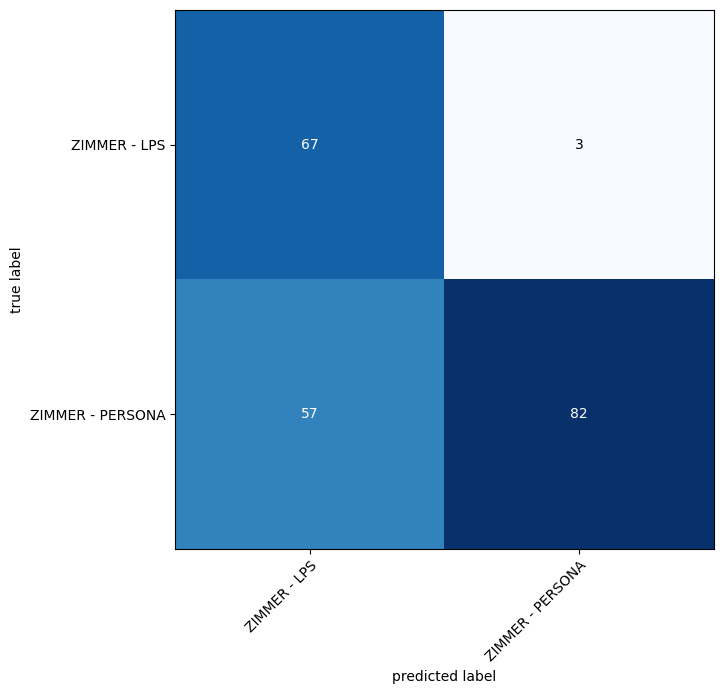

In [25]:
#confusion matrix
trainer_conv.create_dir("../confusion_matrix/")
trainer_conv.confusion_matrix(save_path="../confusion_matrix/")

In [26]:
#Saving the weights
trainer_conv.create_dir("../saved_weights/") #class_name and score
trainer_conv.save_model(save_path="../saved_weights/weights.pth")

In [28]:
#Loading the weights
trainer_conv.model.load_state_dict(torch.load("../saved_weights/weights.pth"))

<All keys matched successfully>

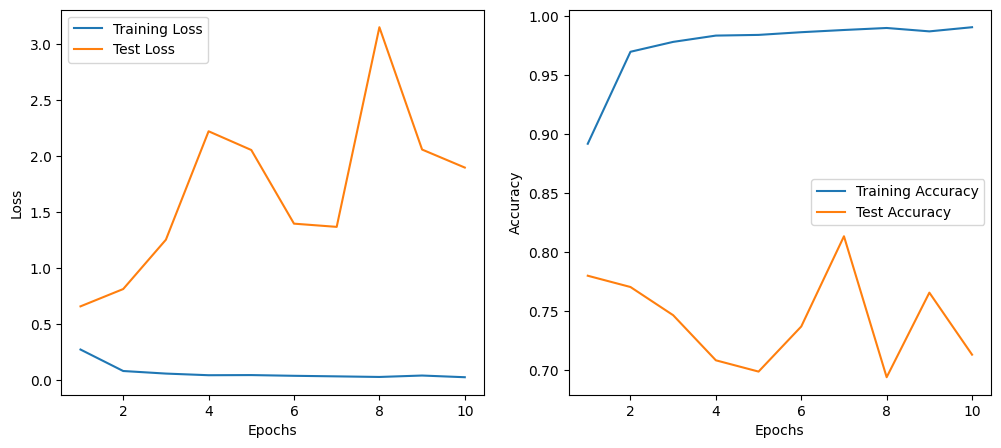

In [29]:
#plotting metrics
trainer_conv.create_dir("../metrics/")
trainer_conv.plot_metrics(save_path="../metrics/")